Welcome to the Movie Quiz!

Who starred in the movie "Ghostbusters"?
1. Ben Affleck
2. Lee Sun-kyun
3. Daniel Craig
4. Bill Murray
Correct!

Who starred in the movie "Borat"?
1. Sacha Baron Cohen
2. Edward Furlong
3. Hilary Swank
4. Angelina Jolie
Incorrect. The correct answer was Sacha Baron Cohen.

Who starred in the movie "Jojo Rabbit"?
1. Denzel Washington
2. Keira Knightley
3. Chiwetel Ejiofor
4. Roman Griffin Davis
Correct!

Who starred in the movie "Shang-Chi and the Legend of the Ten Rings"?
1. Simu Liu
2. Ariadna Gil
3. Dan Aykroyd
4. Sharlto Copley
Incorrect. The correct answer was Simu Liu.

Who is the director of the movie "Gangs of New York"?
1. Martin Scorsese
2. Taika Waititi
3. Edward Zwick
4. Doug Liman
Correct!

Quiz finished! Your final score is: 60 out of 100.
You scored 60.0% of the maximum points.


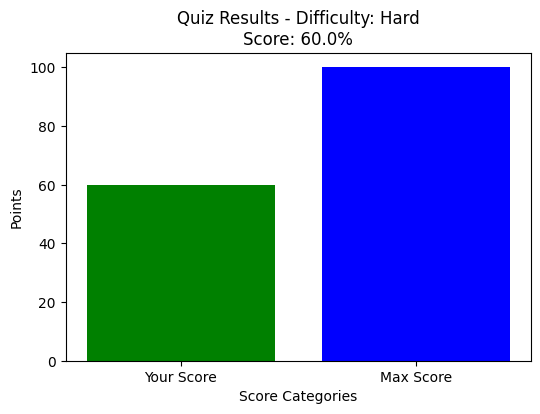

In [12]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

# Load the name.basics.tsv file with necessary columns
name_basics = pd.read_csv(
    'data/name.basics.tsv', 
    sep='\t', 
    usecols=['nconst', 'primaryName', 'primaryProfession', 'knownForTitles'],
    dtype={'nconst': 'str', 'primaryName': 'str', 'primaryProfession': 'str', 'knownForTitles': 'str'}
)

# Load a reduced version of title.basics.csv with required columns
title_basics = pd.read_csv(
    'data/title_basics_reduced.csv', 
    usecols=['tconst', 'titleType', 'primaryTitle', 'genres'],
    dtype={'tconst': 'str', 'titleType': 'str', 'primaryTitle': 'str', 'genres': 'str'}
)

# Load the title.ratings.tsv file with only required columns
title_ratings = pd.read_csv(
    'data/title.ratings.tsv', 
    sep='\t', 
    usecols=['tconst', 'numVotes'],
    dtype={'tconst': 'str', 'numVotes': 'int32'}
)

# Load a reduced version of title.principals.csv with necessary columns
title_principals = pd.read_csv(
    'data/title_principals_reduced.csv',
    usecols=['tconst', 'ordering', 'nconst', 'category'],
    dtype={'tconst': 'str', 'ordering': 'int32', 'nconst': 'str', 'category': 'category'}
)

# Filter out movies that belong to unwanted genres and keep only those labeled as 'movie'
filtered_titles = title_basics[
    (title_basics['titleType'] == 'movie') & 
    (~title_basics['genres'].str.contains(r'Animation|News|\\N|Film-Noir|Talk-Show|Adult|Reality-TV|Game-Show', na=False, regex=True))
]

# Filter title_principals to include only actors, actresses, and directors
filtered_title_principals = title_principals[title_principals['category'].isin(['actor', 'actress', 'director'])]

# Merge filtered titles with ratings to get movies with rating data
filtered_movies_with_ratings = filtered_titles.merge(title_ratings, on='tconst', how='inner')

# Select the top 450 movies based on the number of votes
top_450_votes = filtered_movies_with_ratings.nlargest(450, 'numVotes')

# Divide the top 450 movies into difficulty levels: easy, medium, hard
easy = top_450_votes.iloc[0:150]
medium = top_450_votes.iloc[150:300]
hard = top_450_votes.iloc[300:450]

# Merge title_principals with name_basics to include actor/director names
movie_data = filtered_title_principals.merge(name_basics, on='nconst', how='inner')

# Function to generate quiz questions
def get_questions(level):
    # Assign movies and points based on difficulty level
    if level == 'easy':
        movies = easy
        points = 10
    elif level == 'medium':
        movies = medium
        points = 15
    elif level == 'hard':
        movies = hard
        points = 20
    else:
        print("Invalid level selected. Please choose easy, medium, or hard.")
        return

    questions = []
    selected_movies = set()

    # Filter actors/actresses with ordering=1 (main roles) and merge with selected movies
    actor_data = movie_data[
        (movie_data['category'].isin(['actor', 'actress'])) & (movie_data['ordering'] == 1)
    ].merge(movies, on='tconst')

    # Randomly select 4 actor/actress questions
    actor_questions = random.sample(list(actor_data.to_dict(orient='records')), k=4)
    
    # Add actor/actress questions to the quiz
    for row in actor_questions:
        if row['tconst'] not in selected_movies:
            questions.append((row['primaryTitle'], row['primaryName'], "actor"))
            selected_movies.add(row['tconst'])

    # Filter directors and merge with selected movies
    director_data = movie_data[movie_data['category'] == 'director'].merge(movies, on='tconst')

    # Randomly select 1 director question
    director_questions = random.sample(list(director_data.to_dict(orient='records')), k=1)
    
    # Add director questions to the quiz
    for row in director_questions:
        if row['tconst'] not in selected_movies:
            questions.append((row['primaryTitle'], row['primaryName'], "director"))
            selected_movies.add(row['tconst'])

    return questions, points

# Function to ask a question and display options
def ask_question(movie_title, correct_answer, role):
    alternatives = [correct_answer]

    # Generate a pool of possible wrong answers based on the role
    if role == "actor":
        eligible_actors = movie_data[
            (movie_data['category'].isin(['actor', 'actress'])) &
            (movie_data['ordering'].isin([1, 2])) &
            (movie_data['tconst'].isin(top_450_votes['tconst']))
        ]['primaryName'].unique()
    elif role == "director":
        eligible_directors = movie_data[
            (movie_data['category'] == 'director') &
            (movie_data['tconst'].isin(top_450_votes['tconst']))
        ]['primaryName'].unique()

    # Add random incorrect options until we have 4 alternatives
    while len(alternatives) < 4:
        if role == "actor":
            random_choice = np.random.choice(eligible_actors)
        elif role == "director":
            random_choice = np.random.choice(eligible_directors)

        if random_choice not in alternatives:
            alternatives.append(random_choice)

    # Shuffle the options to randomize the correct answer's position
    np.random.shuffle(alternatives)

    # Display the question and options
    question_text = (
        f"Who starred in the movie \"{movie_title}\"?" if role == "actor"
        else f"Who is the director of the movie \"{movie_title}\"?"
    )
    print(f"\n{question_text}")
    for i, option in enumerate(alternatives, 1):
        print(f"{i}. {option}")
    return alternatives.index(correct_answer) + 1  # Return the correct option's position (1-based index)

# Main function to start the quiz
def start_quiz():
    print("Welcome to the Movie Quiz!")
    
    # Validate difficulty level input
    while True:
        level = input("Choose difficulty level (easy, medium, hard): ").lower()
        if level in ['easy', 'medium', 'hard']:
            break
        else:
            print("Invalid level selected. Please choose 'easy', 'medium', or 'hard'.")
    
    questions, points = get_questions(level)
    if questions is None:
        return
    
    score = 0
    max_score = 5 * points  # Maximum possible score
    question_count = 0  # Counter of valid questions answered
    
    # Iterate through each question in the quiz
    for movie_title, correct_answer, role in questions:
        correct_option = ask_question(movie_title, correct_answer, role)
        
        # Validate user input for their answer
        while True:
            try:
                answer = int(input("Your answer (1-4): "))
                if answer < 1 or answer > 4:
                    print("Invalid input. Please enter a number between 1 and 4.")
                    continue
                break
            except ValueError:
                print("Invalid input. Please enter a number between 1 and 4.")
        
        # Process the user's answer
        question_count += 1
        if answer == correct_option:
            print("Correct!")
            score += points
        else:
            print(f"Incorrect. The correct answer was {correct_answer}.")
    
    print(f"\nQuiz finished! Your final score is: {score} out of {max_score}.")
    
    plot_score(score, max_score, level)  # Plot the quiz results

# Function to plot the user's score as a bar chart
def plot_score(user_score, max_score, level):
    categories = ['Your Score', 'Max Score']
    scores = [user_score, max_score]
    
    # Calculate and display the percentage score
    percentage = np.round((user_score / max_score) * 100, 2)
    print(f"You scored {percentage}% of the maximum points.")

    # Create a bar chart for the scores
    plt.figure(figsize=(6, 4))
    plt.bar(categories, scores, color=['green', 'blue'])
    plt.xlabel("Score Categories")
    plt.ylabel("Points")
    plt.title(f"Quiz Results - Difficulty: {level.capitalize()}\nScore: {percentage}%")
    plt.show()

# Start the quiz
start_quiz()
